In [1]:
import warnings
import os
import copy

from sklearnex import patch_sklearn
import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.impute import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.kernel_approximation import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
from sklearn.covariance import *
from collections import Counter
import sklearn
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 90
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import (
    ADASYN,
    SMOTE,
    RandomOverSampler,
    SVMSMOTE,
    SMOTENC,
    SMOTEN,
    BorderlineSMOTE,
    KMeansSMOTE,
)

plt.style.use("fivethirtyeight")

import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory

# patch_sklearn()
KAGGLE_ENV = 1
DATA_INPUT = '/kaggle/input/marketing-strategy-personalised-offer/'
DATA_OUTPUT = '/kaggle/working/'
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd or 'u164131' in cwd:
    KAGGLE_ENV = 0
    DATA_INPUT = 'kaggle/input/marketing-strategy-personalised-offer/'
    DATA_OUTPUT = 'kaggle/working/'
CACHE = Memory(DATA_OUTPUT + 'joblib', verbose=0)
  

In [2]:
data  = pd.read_csv(DATA_INPUT + 'train_data.csv')
eval_data = pd.read_csv(DATA_INPUT + 'test_data.csv')
data.isna().sum()

offer expiration                            0
income_range                                0
no_visited_Cold drinks                    198
travelled_more_than_15mins_for_offer        0
Restaur_spend_less_than20                 121
Marital Status                              0
restaurant type                             0
age                                         0
Prefer western over chinese                 0
travelled_more_than_25mins_for_offer        0
travelled_more_than_5mins_for_offer         0
no_visited_bars                            93
gender                                      0
car                                     12268
restuarant_same_direction_house             0
Cooks regularly                             0
Customer type                               0
Qualification                               0
is foodie                                   0
no_Take-aways                             144
Job/Job Industry                            0
restuarant_opposite_direction_hous

### EDA and Preprocessing

In [3]:
data  = pd.read_csv(DATA_INPUT + 'train_data.csv')
eval_data = pd.read_csv(DATA_INPUT + 'test_data.csv')
def convert_to_hours(row):
    if "hours" in row['offer expiration']:
#         row['offer expiration'] = int(row['offer expiration'][:-5])
        row['offer expiration'] = 0
    elif "days" in row['offer expiration']:
#         row['offer expiration'] = int(row['offer expiration'][:-4])*24
        row['offer expiration'] = 1
    return row
def save_data():
    global data, eval_data
    data.to_parquet(DATA_OUTPUT + 'data.parquet')
    eval_data.to_parquet(DATA_OUTPUT + 'eval_data.parquet')

data = data.apply(convert_to_hours,axis=1)
eval_data = eval_data.apply(convert_to_hours,axis=1)
def pythonise_col_names(df: pd.DataFrame):
    col_names = list(df.columns)
    rename_stubs = {}
    for x in col_names:
        if x == 'Offer Accepted':
            r = 'target'
            rename_stubs[x]=r
        elif "/" in x:
            r = x.split('/')[1]
            r = r.replace(' ','_').lower()
            rename_stubs[x]=r
        elif "-" in x:
            r = x.replace('-','_').lower()
            r = r.replace(' ','_').lower()
            rename_stubs[x]=r
        elif " " in x:
            r = x.replace(' ','_').lower()
            rename_stubs[x]=r
        else:
            r = x.lower()
            rename_stubs[x] = r 
    return rename_stubs
data.rename(pythonise_col_names(data), inplace=True,axis=1)
eval_data.rename(pythonise_col_names(eval_data), inplace=True,axis=1)
gender_code = {
    'Male':0,
    'Female':1
}
def binarize_gender(row):
    global gender_code
    row['gender'] = gender_code[row['gender']]
    return row
data = data.apply(binarize_gender,axis=1)
eval_data = eval_data.apply(binarize_gender,axis=1)


ages_ord = ['below21','21', '26', '31', '36', '41', '46', '50plus']
ordinal_age_codes =  {x: idx for idx, x in enumerate(ages_ord)}
income_codes = { 
    'Less than ₹12500':1,
    '₹12500 - ₹24999' :2,
    '₹25000 - ₹37499' :3,
    '₹37500 - ₹49999' :4,
    '₹50000 - ₹62499' :5,
    '₹62500 - ₹74999' :6,
    '₹75000 - ₹87499' :7,
    '₹87500 - ₹99999' :8,
    '₹100000 or More' :9,
}

data['ordinal__income_range'] = 0
eval_data['ordinal__income_range'] = 0
data['ordinal__age'] = 0
eval_data['ordinal__age'] = 0

def codify_special_ordinal_range(row):
    global income_codes, ordinal_age_codes
    row['ordinal__income_range'] = income_codes[row['income_range']]
    row['ordinal__age'] = ordinal_age_codes[row['age']]
    return row
data = data.apply(codify_special_ordinal_range,axis=1)
eval_data = eval_data.apply(codify_special_ordinal_range,axis=1)

ordinal_category_codes = {
    '4~8': 3,
    'less1': 1,
    'never': 0,
    '1~3': 2,
    'gt8': 4,
    np.nan: np.nan}

# data = data.apply(codify_cold_drink_consumption,axis=1)
# eval_data = eval_data.apply(codify_cold_drink_consumption,axis=1)
ord_cols = ["restaur_spend_less_than20","no_take_aways","restaur_spend_greater_than20","no_visited_bars","no_visited_cold_drinks"]
col_ord_names = ["ordinal__" + x for x in ord_cols]
data[col_ord_names] = 0
eval_data[col_ord_names] = 0
def codify_ordinal_columns(row):
    global col_ord_names, ordinal_category_codes, ord_cols
    for ord_col,col_ord_name in zip(ord_cols,col_ord_names):
        try:
            row[col_ord_name] = int(ordinal_category_codes[row[ord_col]])
        except ValueError:
            row[col_ord_name] = ordinal_category_codes[row[ord_col]]
    return row
data = data.apply(codify_ordinal_columns,axis=1)
eval_data = eval_data.apply(codify_ordinal_columns,axis=1)

"""
Car Feature:
Label NaN as unknown for now
"""
data.car.fillna("unknown",inplace=True)
eval_data.car.fillna("unknown",inplace=True)

nominal_cs = ['restaurant_type','marital_status','climate',"drop_location","job_industry","customer_type","car","qualification"]
nominal_col_names = ["nominal__" + x for x in nominal_cs]
master_nominals= pd.concat([data[nominal_cs],eval_data[nominal_cs]], ignore_index=True,axis=0)
nominal_encoder = {nc:{} for nc in nominal_cs}
for c in nominal_cs:
    unique_vals = list(master_nominals[c].unique())
    nominal_codes = {x: idx for idx, x in enumerate(unique_vals)}
    nominal_encoder[c] = nominal_codes
data[nominal_col_names] = 0
eval_data[nominal_col_names] = 0
def codify_nominal_columns(row):
    global nominal_col_names, nominal_encoder, nominal_cs
    for nom_col,col_nom_name in zip(nominal_cs,nominal_col_names):
        try:
            row[col_nom_name] = int(nominal_encoder[nom_col][row[nom_col]])
        except ValueError:
            row[col_nom_name] = nominal_encoder[nom_col][row[nom_col]]
    return row
data = data.apply(codify_nominal_columns,axis=1)
eval_data = eval_data.apply(codify_nominal_columns,axis=1)

def drop_const_and_enc_columns(df):
    cols_to_drop = [
        'restaur_spend_less_than20',
        'no_take_aways',
        'restaur_spend_greater_than20',
        'no_visited_bars',
        'no_visited_cold_drinks',
        'restaurant_type',
        'marital_status',
        'climate',
        'qualification',
        'drop_location',
        'job_industry',
        'customer_type',
        'car',
        'income_range',
        "travelled_more_than_5mins_for_offer",
        'age'
    ]
    df = df.drop(cols_to_drop,axis=1)
    return df
data = drop_const_and_enc_columns(data)
eval_data = drop_const_and_enc_columns(eval_data)

data_original_col_order = [
    'offer_expiration',
    'ordinal__income_range',
    'ordinal__no_visited_cold_drinks',
    'travelled_more_than_15mins_for_offer',
    'ordinal__restaur_spend_less_than20',
    'nominal__marital_status',
    'nominal__restaurant_type',
    'ordinal__age',
    'prefer_western_over_chinese',
    'travelled_more_than_25mins_for_offer',
    'ordinal__no_visited_bars',
    'gender',
    'nominal__car',
    'restuarant_same_direction_house',
    'cooks_regularly',
    'nominal__customer_type',
    'nominal__qualification',
    'is_foodie',
    'ordinal__no_take_aways',
    'nominal__job_industry',
    'restuarant_opposite_direction_house',
    'has_children',
    'visit_restaurant_with_rating_(avg)',
    'temperature',
    'ordinal__restaur_spend_greater_than20',
    'travel_time',
    'nominal__climate',
    'nominal__drop_location',
    'prefer_home_food',
    'target'
]
eval_data_original_col_order = copy.deepcopy(data_original_col_order)
eval_data_original_col_order.remove('target')

data = data.loc[:,data_original_col_order]
eval_data = eval_data.loc[:,eval_data_original_col_order]
binary_features= [
    'offer_expiration',
    'travelled_more_than_15mins_for_offer',
    'prefer_western_over_chinese',
    'travelled_more_than_25mins_for_offer',
    'restuarant_same_direction_house',
    'cooks_regularly',
    'is_foodie',
    'restuarant_opposite_direction_house',
    'has_children',
    'prefer_home_food',
    'gender'
]
b_f_rn = {x:"binary__"+ x for x in binary_features}
data.rename(b_f_rn,axis=1,inplace=True)
eval_data.rename(b_f_rn,axis=1,inplace=True)
remaining_ordinals = {
    "visit_restaurant_with_rating_(avg)": "ordinal__rest_rating",
    "temperature": 'ordinal__temperature',
    "travel_time": "ordinal__travel_time"
}
def rename_remaining_ord(df):
    df = df.rename(remaining_ordinals,axis=1)
    return df
data = rename_remaining_ord(data)
eval_data = rename_remaining_ord(eval_data)

target_codes = {"Yes":1,"No":0}
def binarize_target(row):
    global target_codes
    row['target'] = target_codes[row['target']]
    return row
data = data.apply(binarize_target,axis=1)
imputer = IterativeImputer(estimator=RandomForestClassifier(class_weight='balanced',random_state=42,min_impurity_decrease=0.0001,n_jobs=-1,max_features=None),sample_posterior=False,initial_strategy='most_frequent',random_state=42)
X = data[eval_data.columns]
y = data.target
with parallel_backend('threading', n_jobs=24):
    data_enc = imputer.fit_transform(X)
    eval_data_enc = imputer.transform(eval_data)
    
data.loc[:,eval_data.columns] = data_enc
eval_data.loc[:,:] = eval_data_enc
data = data.astype(np.uint32)
eval_data = eval_data.astype(np.uint32)
save_data()

### Imputing Offshore

```python
imputer = IterativeImputer(estimator=RandomForestClassifier(class_weight='balanced',random_state=42,n_jobs=2),sample_posterior=False,initial_strategy='most_frequent',random_state=42)
with parallel_backend('threading', n_jobs=2):
    data_enc = imputer.fit_transform(X)
    eval_data_enc = imputer.transform(eval_data)
```

In [51]:
data = pd.read_parquet(DATA_OUTPUT+'data.parquet')
eval_data = pd.read_parquet(DATA_OUTPUT+'eval_data.parquet')
X = data[eval_data.columns]
y = data.target

In [5]:
data[data.binary__gender==1]['target'].value_counts()

1    3492
0    2843
Name: target, dtype: int64

In [6]:
clf = RandomForestClassifier(class_weight='balanced',random_state=42)
cross_validate(clf,X,y,scoring='f1_macro',return_train_score=True)
# data.binary__restuarant_opposite_direction_house

{'fit_time': array([1.7330699 , 1.72200036, 1.71003985, 1.70294547, 1.69720531]),
 'score_time': array([0.09949923, 0.0971365 , 0.09680533, 0.09735417, 0.09686446]),
 'test_score': array([0.56882047, 0.57624599, 0.58766821, 0.57124021, 0.59949497]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [9]:
nominal = [x for x in eval_data.columns if "nominal_" in x]
ordinal = [x for x in eval_data.columns if "ordinal_" in x]
binary = [x for x in eval_data.columns if "binary_" in x]
# data = pd.get_dummies(data,columns=nominal, dtype=np.uint32)

In [12]:
!pip install phik


In [23]:
!git clone https://github.com/KaveIO/PhiK.git
    

Cloning into 'PhiK'...
remote: Enumerating objects: 960, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 960 (delta 76), reused 64 (delta 53), pack-reused 806
Receiving objects: 100% (960/960), 1.32 MiB | 2.98 MiB/s, done.
Resolving deltas: 100% (560/560), done.


In [24]:
!pip3 install -e PhiK/

Obtaining file:///kaggle/working/PhiK
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for phik (pyproject.toml) ... done
  Created wheel for phik: filename=phik-0.12.2-0.editable-py3-none-any.whl size=5857 sha256=54f1350e67ad592b4146f2ffb7510298fb429862e60d4c6cdf0abd91592431f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-pr6qoyix/wheels/f1/56/b4/f15858c855530085629b27596b349f2ed2b6161f632feaee5e
Successfully built phik
  Attempting uninstall: phik
    Found existing installation: phik 0.12.2
    Uninstalling phik-0.12.2:
      Successfully uninstalled phik-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markup

interval columns not set, guessing: ['binary__offer_expiration', 'ordinal__income_range', 'ordinal__no_visited_cold_drinks', 'binary__travelled_more_than_15mins_for_offer', 'ordinal__restaur_spend_less_than20', 'nominal__marital_status', 'nominal__restaurant_type', 'ordinal__age', 'binary__prefer_western_over_chinese', 'binary__travelled_more_than_25mins_for_offer', 'ordinal__no_visited_bars', 'binary__gender', 'nominal__car', 'binary__restuarant_same_direction_house', 'binary__cooks_regularly', 'nominal__customer_type', 'nominal__qualification', 'binary__is_foodie', 'ordinal__no_take_aways', 'nominal__job_industry', 'binary__restuarant_opposite_direction_house', 'binary__has_children', 'ordinal__rest_rating', 'ordinal__temperature', 'ordinal__restaur_spend_greater_than20', 'ordinal__travel_time', 'nominal__climate', 'nominal__drop_location', 'binary__prefer_home_food', 'target']


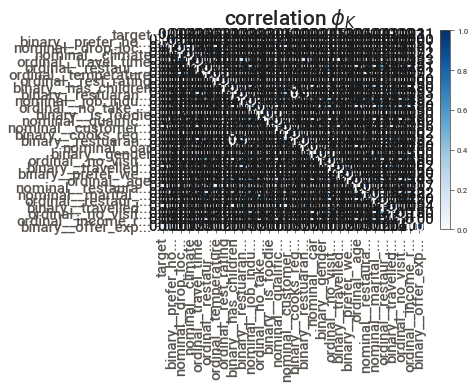

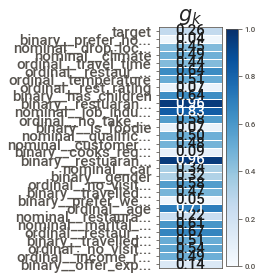

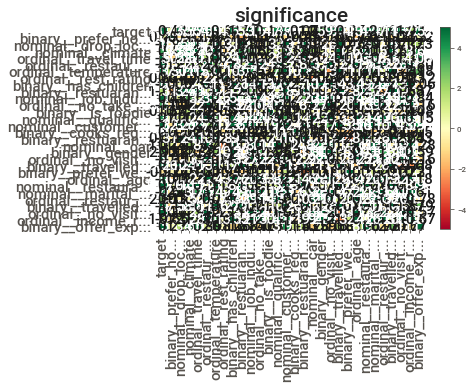

In [58]:
from phik import report
data_bins = data.nunique().to_dict()
a = phik.report.correlation_report(data=data,lambda_significance='pearson',significance_method='hybrid',bins=data_bins,noise_correction=True,pdf_file_name='phik.pdf',do_outliers=False)

In [54]:
nominal

['nominal__marital_status',
 'nominal__restaurant_type',
 'nominal__car',
 'nominal__customer_type',
 'nominal__qualification',
 'nominal__job_industry',
 'nominal__climate',
 'nominal__drop_location']

In [59]:
phi_mat = data.phik_matrix(interval_cols=ordinal+["nominal__qualification",'nominal__climate'],bins=data_bins)

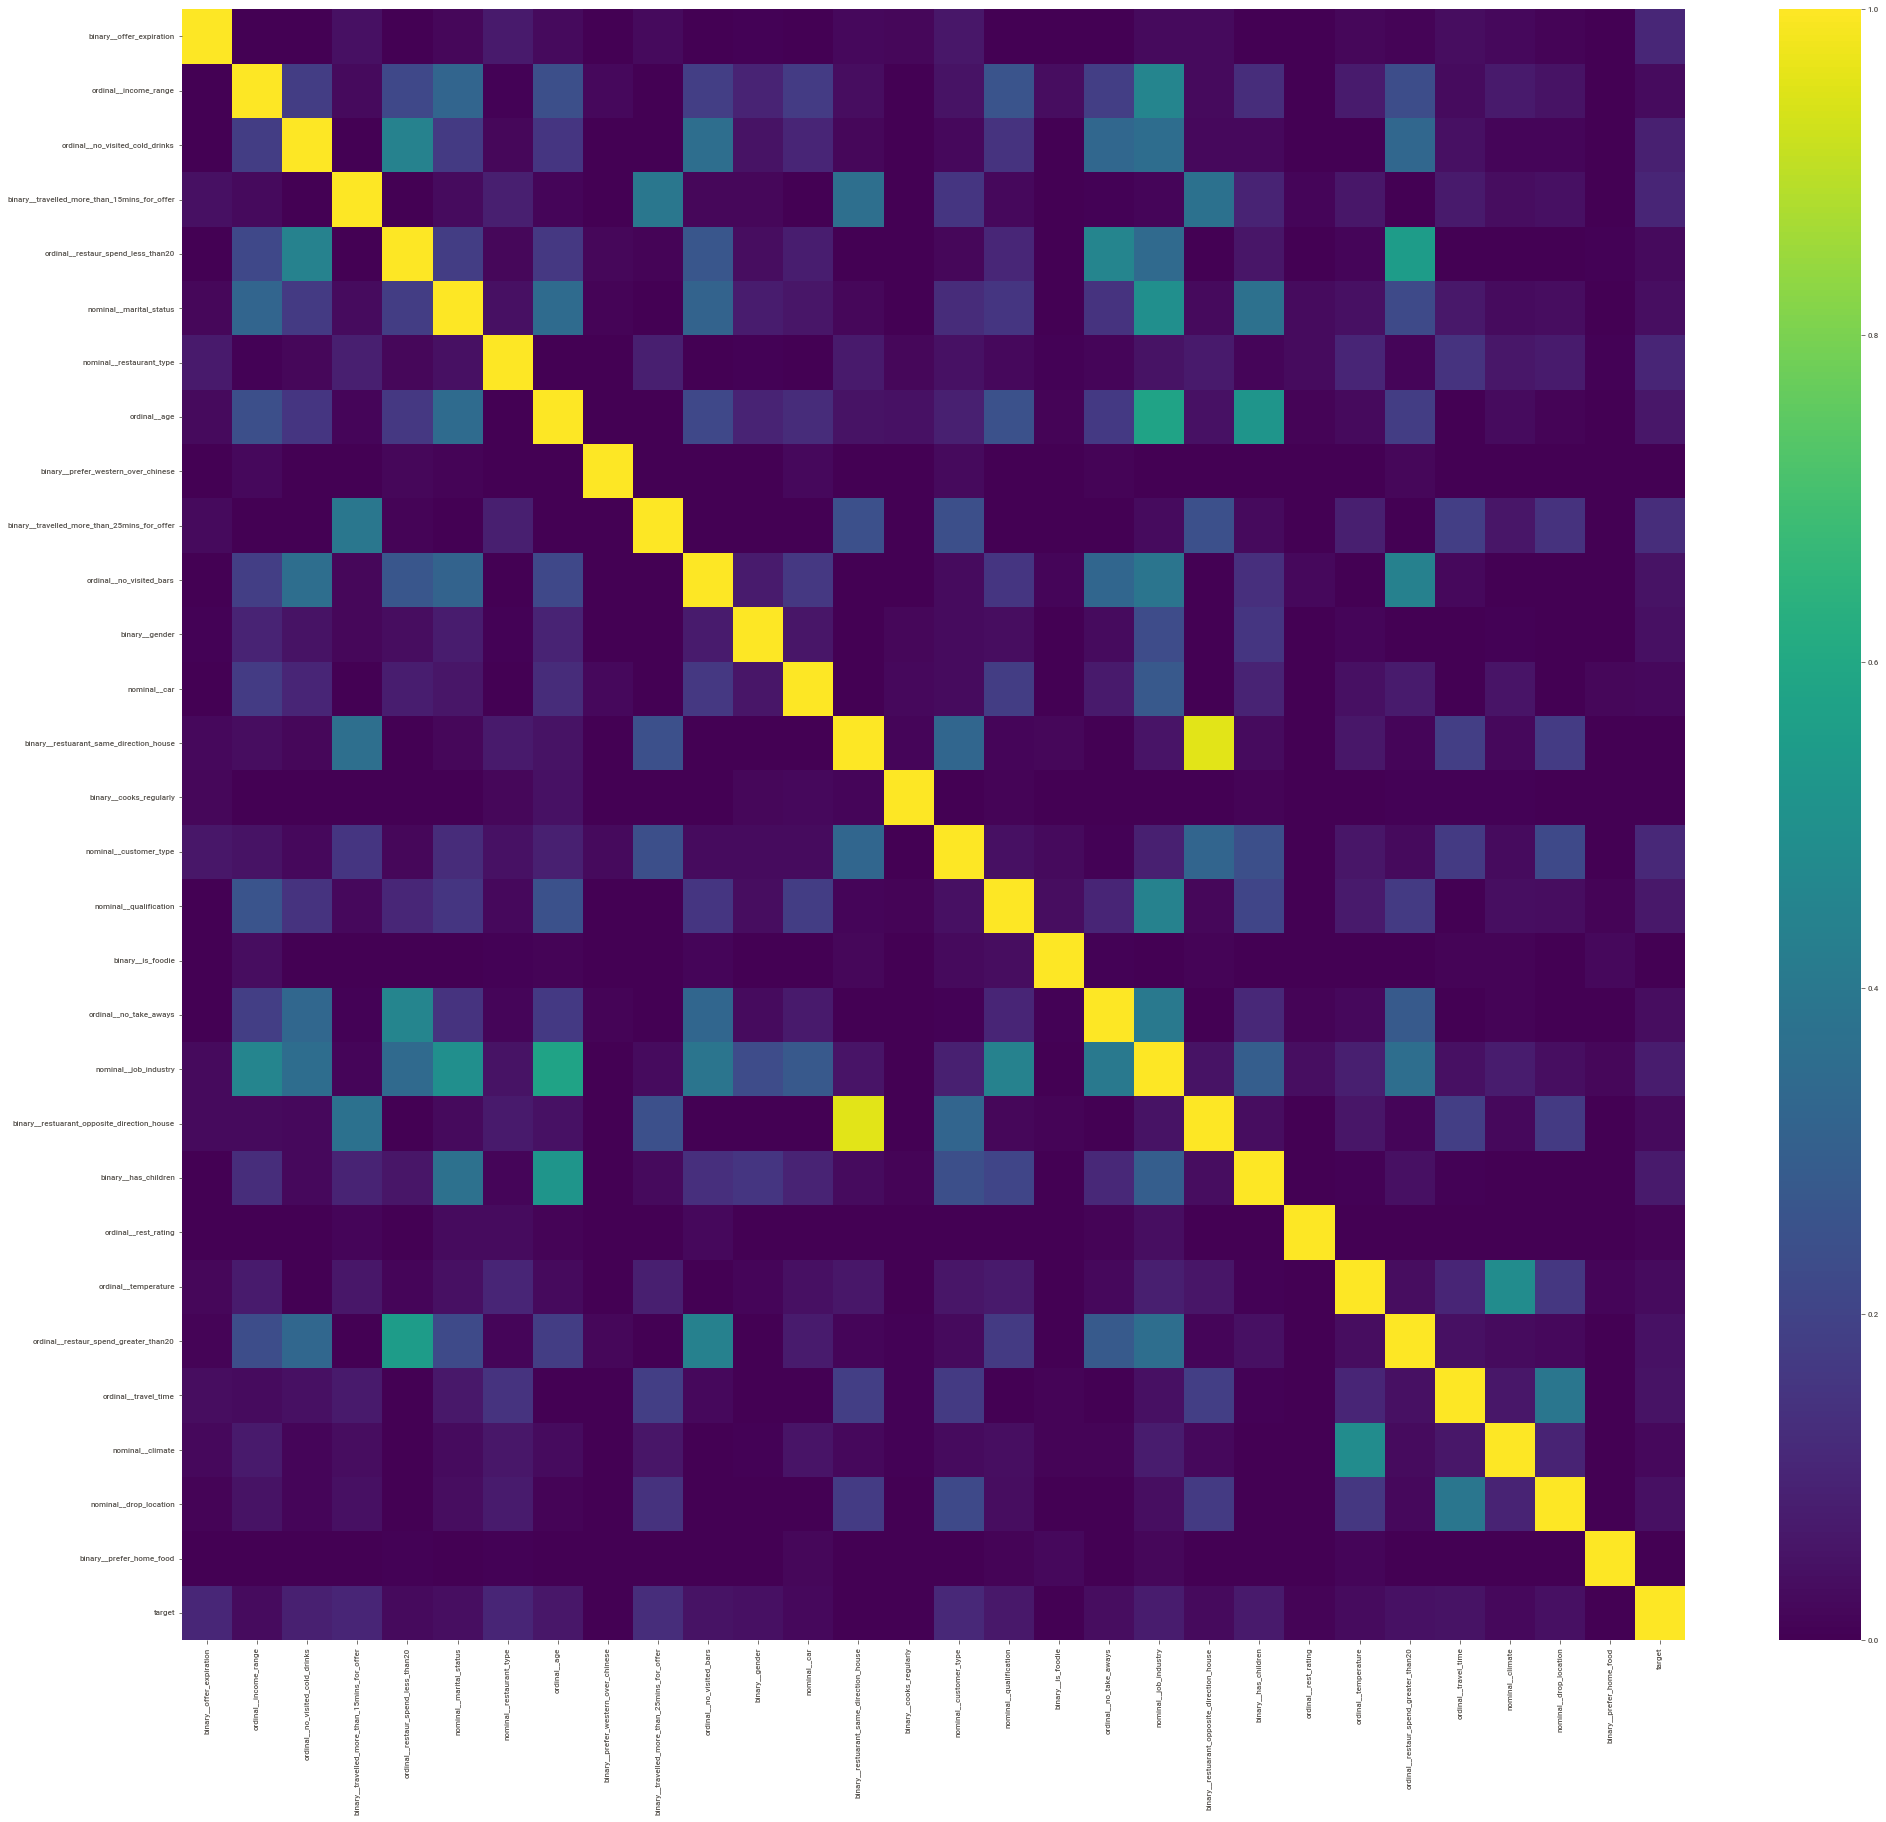

In [60]:
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(30,30))
sns.heatmap(phi_mat,cmap='viridis')
_=plt.xticks(rotation=90)
# _=plt.yticks(rotation=90)

In [ ]:
global_phi = data.significance_matrix(interval_cols=ordinal,bins=data_bins)

In [46]:
related_features = (((phi_mat > 0.3).sum(axis=0)) > 1).to_dict()
relf = []
print("Features that have Linear or Non Linear Relationships\n\n".upper())
for k, v in related_features.items():
    if v:
#         print("\t" + k)
        relf.append(k)
crr = phi_mat
relations = {f: {} for f in relf}
for f in relf:
    f_crr = crr[f].abs()
    #     print('\n')
    #     print(f_crr[f_crr > 0.3])
    #     print('\n')
    f_rel = crr[f][f_crr[f_crr > 0.3].index].to_dict()
    del f_rel[f]
    relations[f] = f_rel

FEATURES THAT HAVE LINEAR OR NON LINEAR RELATIONSHIPS




In [49]:
from pprint import pprint as pp
pp(relations)

{'binary__has_children': {'nominal__marital_status_0': 0.5509429122516782,
                          'nominal__marital_status_1': 0.529885622878984,
                          'ordinal__age': 0.520951715237399},
 'binary__restuarant_opposite_direction_house': {'binary__restuarant_same_direction_house': 0.9550712371834301,
                                                 'binary__travelled_more_than_15mins_for_offer': 0.37431108765131293,
                                                 'nominal__customer_type_0': 0.31428229633225613,
                                                 'nominal__drop_location_1': 0.4229215259869836},
 'binary__restuarant_same_direction_house': {'binary__restuarant_opposite_direction_house': 0.9550712371834301,
                                             'binary__travelled_more_than_15mins_for_offer': 0.36082474237014767,
                                             'nominal__customer_type_0': 0.3169294832530428,
                                            

In [50]:
nominal

['nominal__marital_status',
 'nominal__restaurant_type',
 'nominal__car',
 'nominal__customer_type',
 'nominal__qualification',
 'nominal__job_industry',
 'nominal__climate',
 'nominal__drop_location']

In [ ]:
[
#     'nominal__marital_status',
#     'nominal__restaurant_type',
#     'nominal__car',
#     'nominal__customer_type',
#     'nominal__qualification',
    'nominal__job_industry',
#     'nominal__climate',
#     'nominal__drop_location'
]